In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pickle
import os.path
import scipy.stats as stats
import numpy as np
import pandas as pd

In [2]:
# Try to cache the data with pickle if set to True
CACHE = True

# 1st Part : Bachelor students  

**First, we examine the details of IS-Academia web form to find out the various form parameters
that we need for a successful request!**

In [3]:
# We use the form URL of public is-academia
req = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')

In [4]:
main = BeautifulSoup(req.text, 'html.parser')

In [5]:
print(main.body.prettify())

<body alink="#666666" bgcolor="#ffffff" link="#666666" marginheight="0" marginwidth="5" vlink="#666666">
 <div class="filtres">
  <form action="!GEDPUBLICREPORTS.filter" method="GET" name="f">
   <input name="ww_b_list" type="hidden" value="1">
    <input name="ww_i_reportmodel" type="hidden" value="133685247">
     <input name="ww_c_langue" type="hidden" value="">
      <h1 id="titre">
       Liste des étudiants inscrits par semestre
      </h1>
      <table border="0" id="format">
       <tr>
        <th>
         Format:
        </th>
       </tr>
       <tr>
        <td>
         <input checked="" name="ww_i_reportModelXsl" type="radio" value="133685270">
          html
         </input>
        </td>
       </tr>
       <tr>
        <td>
         <input name="ww_i_reportModelXsl" type="radio" value="133685271">
          xls
         </input>
        </td>
       </tr>
      </table>
      <h1>
      </h1>
      <table border="0" id="filtre">
       <tr>
        <th>
         Unit

**We can see that the Unité académique/Academic Unit input has the name `zz_x_UNITE_ACAD` and consists of one option for each section.**

In [6]:
# Find the Unité académique element in the form
unit = main.find(attrs={"name": "zz_x_UNITE_ACAD"})
print(unit.prettify())

<input name="zz_x_UNITE_ACAD" type="hidden" value="">
 <select name="ww_x_UNITE_ACAD" onchange="document.f.zz_x_UNITE_ACAD.value=document.f.ww_x_UNITE_ACAD.options[document.f.ww_x_UNITE_ACAD.selectedIndex].text">
  <option value="null">
  </option>
  <option value="942293">
   Architecture
  </option>
  <option value="246696">
   Chimie et génie chimique
  </option>
  <option value="943282">
   Cours de mathématiques spéciales
  </option>
  <option value="637841336">
   EME (EPFL Middle East)
  </option>
  <option value="942623">
   Génie civil
  </option>
  <option value="944263">
   Génie mécanique
  </option>
  <option value="943936">
   Génie électrique et électronique
  </option>
  <option value="2054839157">
   Humanités digitales
  </option>
  <option value="249847">
   Informatique
  </option>
  <option value="120623110">
   Ingénierie financière
  </option>
  <option value="946882">
   Management de la technologie
  </option>
  <option value="944590">
   Mathématiques
  </opti

**We can easily extract the 'value' (section id) for the Informatique section using BeautifulSoup:**

In [7]:
# We use soup.find instead of soup.find_all because we can see
# that each unit has a unique name.
unit_IN_option = unit.find(text="Informatique")
unit_IN_id = unit_IN_option.parent['value']
unit_IN_id

'249847'

**Now we look at the options for the Year field**

In [8]:
period = main.find(attrs={"name": "zz_x_PERIODE_ACAD"})
print(period.prettify())

<input name="zz_x_PERIODE_ACAD" type="hidden" value="">
 <select name="ww_x_PERIODE_ACAD" onchange="document.f.zz_x_PERIODE_ACAD.value=document.f.ww_x_PERIODE_ACAD.options[document.f.ww_x_PERIODE_ACAD.selectedIndex].text">
  <option value="null">
  </option>
  <option value="355925344">
   2016-2017
  </option>
  <option value="213638028">
   2015-2016
  </option>
  <option value="213637922">
   2014-2015
  </option>
  <option value="213637754">
   2013-2014
  </option>
  <option value="123456101">
   2012-2013
  </option>
  <option value="123455150">
   2011-2012
  </option>
  <option value="39486325">
   2010-2011
  </option>
  <option value="978195">
   2009-2010
  </option>
  <option value="978187">
   2008-2009
  </option>
  <option value="978181">
   2007-2008
  </option>
 </select>
</input>


In [9]:
period_options = period.find_all("option")

In [10]:
for option in period_options:
    print(option['value'])

null
355925344
213638028
213637922
213637754
123456101
123455150
39486325
978195
978187
978181


**Great! We have an ID for each academic year. We can get rid of the first option, which is null**

In [11]:
period_options = period_options[1:]

In [12]:
# Create a dict mapping year period to period id 
year_dict = {option.text : option["value"] for option in period_options}
year_dict

{'2007-2008': '978181',
 '2008-2009': '978187',
 '2009-2010': '978195',
 '2010-2011': '39486325',
 '2011-2012': '123455150',
 '2012-2013': '123456101',
 '2013-2014': '213637754',
 '2014-2015': '213637922',
 '2015-2016': '213638028',
 '2016-2017': '355925344'}

**Now let's find out how to choose the semester type in the form**

In [13]:
semester = main.find(attrs={"name": "zz_x_PERIODE_PEDAGO"})
print(semester.prettify())

<input name="zz_x_PERIODE_PEDAGO" type="hidden" value="">
 <select name="ww_x_PERIODE_PEDAGO" onchange="document.f.zz_x_PERIODE_PEDAGO.value=document.f.ww_x_PERIODE_PEDAGO.options[document.f.ww_x_PERIODE_PEDAGO.selectedIndex].text">
  <option value="null">
  </option>
  <option value="249108">
   Bachelor semestre 1
  </option>
  <option value="249114">
   Bachelor semestre 2
  </option>
  <option value="942155">
   Bachelor semestre 3
  </option>
  <option value="942163">
   Bachelor semestre 4
  </option>
  <option value="942120">
   Bachelor semestre 5
  </option>
  <option value="2226768">
   Bachelor semestre 5b
  </option>
  <option value="942175">
   Bachelor semestre 6
  </option>
  <option value="2226785">
   Bachelor semestre 6b
  </option>
  <option value="2230106">
   Master semestre 1
  </option>
  <option value="942192">
   Master semestre 2
  </option>
  <option value="2230128">
   Master semestre 3
  </option>
  <option value="2230140">
   Master semestre 4
  </option>


In [14]:
options = semester.find_all("option")
options

[<option value="null"></option>,
 <option value="249108">Bachelor semestre 1</option>,
 <option value="249114">Bachelor semestre 2</option>,
 <option value="942155">Bachelor semestre 3</option>,
 <option value="942163">Bachelor semestre 4</option>,
 <option value="942120">Bachelor semestre 5</option>,
 <option value="2226768">Bachelor semestre 5b</option>,
 <option value="942175">Bachelor semestre 6</option>,
 <option value="2226785">Bachelor semestre 6b</option>,
 <option value="2230106">Master semestre 1</option>,
 <option value="942192">Master semestre 2</option>,
 <option value="2230128">Master semestre 3</option>,
 <option value="2230140">Master semestre 4</option>,
 <option value="2335667">Mineur semestre 1</option>,
 <option value="2335676">Mineur semestre 2</option>,
 <option value="2063602308">Mise à niveau</option>,
 <option value="249127">Projet Master automne</option>,
 <option value="3781783">Projet Master printemps</option>,
 <option value="953159">Semestre automne</optio

In [15]:
# Only keep options that contain "Bachelor"
bachelor_options = [option for option in options if "Bachelor" in option.text]
bachelor_options

[<option value="249108">Bachelor semestre 1</option>,
 <option value="249114">Bachelor semestre 2</option>,
 <option value="942155">Bachelor semestre 3</option>,
 <option value="942163">Bachelor semestre 4</option>,
 <option value="942120">Bachelor semestre 5</option>,
 <option value="2226768">Bachelor semestre 5b</option>,
 <option value="942175">Bachelor semestre 6</option>,
 <option value="2226785">Bachelor semestre 6b</option>]

In [16]:
# Create a dict mapping semester number to semester id 
bachelor_dict = {option.text : option["value"] for option in bachelor_options}
bachelor_dict

{'Bachelor semestre 1': '249108',
 'Bachelor semestre 2': '249114',
 'Bachelor semestre 3': '942155',
 'Bachelor semestre 4': '942163',
 'Bachelor semestre 5': '942120',
 'Bachelor semestre 5b': '2226768',
 'Bachelor semestre 6': '942175',
 'Bachelor semestre 6b': '2226785'}

**Now we have enough parameters to try to do a request to the request url. We found it using postman, it's a simple GET request on `http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml`. We analysed the request and the field names are the same as the `input` names, but with leading `ww` instead of `zz`, for instance: `zz_x_UNITE_ACAD` becomes `ww_x_UNITE_ACAD`.**

In [17]:
BASE_URL = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html"

In [18]:
fields = {"unit": "ww_x_UNITE_ACAD", "year": "ww_x_PERIODE_ACAD", "semester": "ww_x_PERIODE_PEDAGO"}
fields

{'semester': 'ww_x_PERIODE_PEDAGO',
 'unit': 'ww_x_UNITE_ACAD',
 'year': 'ww_x_PERIODE_ACAD'}

**Let's try to do a request of the Bachelor semester 1 for 2016-2017**

In [19]:
params = {fields["unit"] : unit_IN_id, fields["year"] : year_dict["2016-2017"], fields["semester"] : bachelor_dict["Bachelor semestre 1"]}
params

{'ww_x_PERIODE_ACAD': '355925344',
 'ww_x_PERIODE_PEDAGO': '249108',
 'ww_x_UNITE_ACAD': '249847'}

In [20]:
answer = requests.get(BASE_URL, params=params)
answer.status_code

404

In [21]:
answer.text

'<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n<HTML><HEAD>\n<TITLE>404 Not Found</TITLE>\n</HEAD><BODY>\n<H1>Not Found</H1>\nThe requested URL /imoniteur_ISAP/!GEDPUBLICREPORTS.html was not found on this server.<P>\n</BODY></HTML>\n'

**We get a 404: we need more fields to have a correct query. We noticed on postman that we needed to fill two or three other fields, which we're going to get from the form**

In [22]:
all_inputs = main.body.find_all("input")
all_inputs_values = {inp["name"] : inp["value"] for inp in all_inputs}
print(all_inputs_values)

{'zz_x_PERIODE_ACAD': '', 'ww_i_reportModelXsl': '133685271', 'zz_x_UNITE_ACAD': '', 'zz_x_HIVERETE': '', 'zz_x_PERIODE_PEDAGO': '', 'ww_c_langue': '', 'ww_b_list': '1', 'ww_i_reportmodel': '133685247', 'dummy': 'ok'}


**We see on postman that the additional fields we need are `ww_i_reportmodel`, `ww_i_reportModelXsl.` Let's try again!**

In [23]:
params["ww_i_reportmodel"] = all_inputs_values["ww_i_reportmodel"]
params["ww_i_reportModelXsl"] = all_inputs_values["ww_i_reportModelXsl"]

In [24]:
params

{'ww_i_reportModelXsl': '133685271',
 'ww_i_reportmodel': '133685247',
 'ww_x_PERIODE_ACAD': '355925344',
 'ww_x_PERIODE_PEDAGO': '249108',
 'ww_x_UNITE_ACAD': '249847'}

In [25]:
answer = requests.get(BASE_URL, params=params)
answer.status_code

200

In [26]:
answersoup = BeautifulSoup(answer.text, "html.parser")
print(answersoup.prettify())

<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type">
   <title>
   </title>
  </meta>
 </head>
 <body alink="#666666" bgcolor="#ffffff" link="#666666" marginheight="0" marginwidth="5" vlink="#666666">
  <script>
   function mailList(x) {
   var vtop = (screen.height-200)/2;
   var vleft=(screen.width-600)/2;
   var w=open("", "emaillist", "Scrollbars=1,resizable=1,width=600,height=200,top="+vtop+",left="+vleft);
   w.document.write(x);
   w.document.close();
   w.focus();
  }
  </script>
  <table>
   <tr>
    <th colspan="10">
     Ces listes d'étudiants ne seront définitives qu'à la mi-août une fois la commission d'admission bachelor et la conférence d'examen passées afin de s'assurer que tous les étudiants nouvellement admis à l'EPFL y figurent et que les étudiants en situation d'échec définitif soient rayés de ces listes
    </th>
   </tr>
  </table>
 </body>
</html>
<!-- OpenXml:0.01s  agent ctrl:0.00s  xml:0.03s  xsl extr&stylesheet:0.00s  xsl after

**Even though we get a 200, this is still not the output we need. One last parameter is missing, but it is not in the form as an input. By inspecting our postman requests, we noticed that `ww_x_GPS` is included.**

In [27]:
# We found out using postman interceptor that setting the value to -1 requests all of the tables for a request ("Tous")
params["ww_x_GPS"] = -1

In [28]:
answer = requests.get(BASE_URL, params=params)
answer.status_code

200

In [29]:
answersoup = BeautifulSoup(answer.text, "html.parser")
#print(answersoup.prettify()) # NOTE 21-Oct-2016 commented out for peer review (notebook didn't render on github)

** It works!**

In [30]:
lines = answersoup.body.table.find_all('tr')
print("\n=============\n".join([str(line) for line in lines[:5]]))

<tr><th colspan="10">
    Ces listes d'étudiants ne seront définitives qu'à la mi-août une fois la commission d'admission bachelor et la conférence d'examen passées afin de s'assurer que tous les étudiants nouvellement admis à l'EPFL y figurent et que les étudiants en situation d'échec définitif soient rayés de ces listes
   </th></tr>
<tr><th colspan="12"><font color="black">Informatique, 2016-2017, Bachelor semestre 1</font>
 (235 ét.)
    </th></tr>
<tr><th>Civilité</th><th>Nom Prénom</th><th>Orientation Bachelor</th><th>Orientation Master</th><th>Spécialisation</th><th>Filière opt.</th><th>Mineur</th><th>Statut</th><th>Type Echange</th><th>Ecole Echange</th><th>No Sciper</th></tr>
<tr><td style="white-space:nowrap">Monsieur</td><td style="white-space:nowrap">Abbey Alexandre</td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowr

In [31]:
lines[-1]

<tr><td style="white-space:nowrap">Monsieur</td><td style="white-space:nowrap">Zumbach Yves Arnaud</td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap">Présent</td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td>269845</td><td style="white-space:nowrap"><a href="mailto:"></a></td><td style="white-space:nowrap"></td></tr>

**We can see that all lines except the three first ones correspond to students. Let's discard the first two.**

In [32]:
header = lines[2]
lines = lines[3:]

In [33]:
header

<tr><th>Civilité</th><th>Nom Prénom</th><th>Orientation Bachelor</th><th>Orientation Master</th><th>Spécialisation</th><th>Filière opt.</th><th>Mineur</th><th>Statut</th><th>Type Echange</th><th>Ecole Echange</th><th>No Sciper</th></tr>

**We are interested in "Civilité" (gender) and "No Sciper", "Spécialisation", and "Mineur". **

In [34]:
df = pd.DataFrame()
items = []
for line in lines:
    td_list = line.find_all("td")
    items.append([th.text for th in td_list])
    
df = df.append(items)

# Keep: gender 0, name 1, specialization 4, minor 6, sciper 10
df = df[[0,1,4,6,10]]
df.columns = ['Gender', 'Name', 'Specialization', 'Minor', 'SCIPER']
# We set the index to be the SCIPER number
df.index = [item[10] for item in items]

In [35]:
df.sample(10)

,Gender,Name,Specialization,Minor,SCIPER
257714,Monsieur,Gessler Frédéric,,,257714
276323,Monsieur,Zeller Corentin Luc Claude,,,276323
260750,Monsieur,Mettler Kévin,,,260750
274690,Monsieur,Carrier Théo Simon,,,274690
274748,Monsieur,Berla Francesco,,,274748
269521,Monsieur,Baudat Adrian,,,269521
269880,Madame,Montemagni Camille Valentine Axelle,,,269880
270494,Monsieur,Poulsen Niels Jens,,,270494
272803,Monsieur,Hoffstetter Ludo,,,272803
262259,Monsieur,Brunell Roald Linneus Nassim,,,262259


In [36]:
df.index.is_unique

True

**Sciper is unique, as it should be.**

In [37]:
df.groupby("Gender")["Gender"].count()

Gender
Madame       30
Monsieur    205
Name: Gender, dtype: int64

**Here we create two functions to create a dataframe for each semester**
* `make_params` is an utility function that creates the parameters for the http request
* `get_df_for_semester` makes a request (or takes from the cache) to return a nice dataframe containing one semester of course records.


In [38]:
def make_params(year_str, semester_str, semester_dict):
    params = {
          fields["year"] : year_dict[year_str],
          fields["semester"] : semester_dict[semester_str]}
    const_params = {fields["unit"] : unit_IN_id, 
                "ww_i_reportmodel" : all_inputs_values["ww_i_reportmodel"],
                "ww_i_reportModelXsl" : all_inputs_values["ww_i_reportModelXsl"],
                "ww_x_GPS" : -1}
    params.update(const_params)
    return params

def get_df_for_semester(year_str, semester_str, semester_dict):
    params = make_params(year_str, semester_str, semester_dict)
    
    # If we want to cache our server requests (used for testing
    # to avoid repeat requests to the server)
    if CACHE:
        CACHE_DIR = "cache"
        
        # Create directory if it doesn't exist
        if not os.path.exists(CACHE_DIR):
            os.makedirs(CACHE_DIR)
        backup_path = os.path.join(CACHE_DIR, year_str + semester_str + ".bak")        
        
        # If backup exists
        if os.path.isfile(backup_path):
            with open(backup_path, 'rb') as handle:
                answer = pickle.load(handle)
        else:
            answer = requests.get(BASE_URL, params=params)
            
            # Create backup
            with open(backup_path, 'wb') as handle:
                pickle.dump(answer, handle)
    # If we do not want to use cache
    else:
        answer = requests.get(BASE_URL, params=params)

    answersoup = BeautifulSoup(answer.text, "html.parser")
    lines = answersoup.body.table.find_all('tr')
    
    df = pd.DataFrame()
    
    # We assume we get a positive result if there are more than three lines
    # because the student data starts on the fourth line
    if len(lines) > 3:
        lines = lines[3:]
        items = []
        for line in lines:
            td_list = line.find_all("td")
            
            ## We break if we encounter an error, for example HES passerelle. 
            ## We do not consider students coming from the HES passerelle as they arrive at EPFL only at the third semester.
            if(len(td_list)) == 0:
                break
            items.append([th.text for th in td_list])

        df = df.append(items)

        # Keep: gender 0, name 1, specialization 4, minor 6, sciper 10
        df = df[[0,1,4,6,10]]
        sciper_index = [item[10] for item in items] 
        year_index = [year_str for item in items]
        semester_index = [semester_str for item in items]
        df.index = [sciper_index, year_index, semester_index]
        df.columns = ['Gender', 'Name', 'Specialization', 'Minor', 'SCIPER']
        df["Year"] = year_str
        df["Semester"] = semester_str

    return df

# Check that Tim appears in the list!
df_ex = get_df_for_semester("2013-2014", "Bachelor semestre 3", bachelor_dict)
df_ex.loc['223744']

,,Gender,Name,Specialization,Minor,SCIPER,Year,Semester
2013-2014,Bachelor semestre 3,Monsieur,Lottaz Timothée,,,223744,2013-2014,Bachelor semestre 3


**Tim indeed shows up in our dataframe! Now let's request all of the Informatique bachelor data and concatenate it all into a single dataframe**

In [39]:
# Concatenate all bachelor semesters
dfs = []
for year in year_dict:
    for bachelor in bachelor_dict:
        dfs.append(get_df_for_semester(year, bachelor, bachelor_dict))
        
df_bachelors = pd.concat(dfs)
df_bachelors.sample(5)

,,,Gender,Name,Specialization,Minor,SCIPER,Year,Semester
185754,2009-2010,Bachelor semestre 3,Monsieur,Testuz Romain Pierre,,,185754,2009-2010,Bachelor semestre 3
194171,2011-2012,Bachelor semestre 4,Monsieur,Quarta Jonny,,,194171,2011-2012,Bachelor semestre 4
176382,2009-2010,Bachelor semestre 6,Monsieur,Pamingle Michael Maurice Roger,,,176382,2009-2010,Bachelor semestre 6
239765,2013-2014,Bachelor semestre 1,Monsieur,Nadjeh Karim Yessine,,,239765,2013-2014,Bachelor semestre 1
193735,2009-2010,Bachelor semestre 2,Monsieur,Ramandrosoa Ramambason Mikaela Jese,,,193735,2009-2010,Bachelor semestre 2


In [40]:
# Example, let's see Tim
df_bachelors[df_bachelors['SCIPER']=="223744"].sort_values(["Year", "Semester"])

Gender             Name  \
223744 2012-2013 Bachelor semestre 1  Monsieur  Lottaz Timothée   
                 Bachelor semestre 2  Monsieur  Lottaz Timothée   
       2013-2014 Bachelor semestre 3  Monsieur  Lottaz Timothée   
                 Bachelor semestre 4  Monsieur  Lottaz Timothée   
       2014-2015 Bachelor semestre 5  Monsieur  Lottaz Timothée   
                 Bachelor semestre 6  Monsieur  Lottaz Timothée   
       2015-2016 Bachelor semestre 5  Monsieur  Lottaz Timothée   
                 Bachelor semestre 6  Monsieur  Lottaz Timothée   

                                     Specialization Minor  SCIPER       Year  \
223744 2012-2013 Bachelor semestre 1                       223744  2012-2013   
                 Bachelor semestre 2                       223744  2012-2013   
       2013-2014 Bachelor semestre 3                       223744  2013-2014   
                 Bachelor semestre 4                       223744  2013-2014   
       2014-2015 Bachelor semestre 5                       223744  2014-2015   
                 Bachelor semestre 6                       223744  2014-2015   
       2015-2016 Bachelor semestre 5                       223744  2015-2016   
                 Bachelor semestre 6                       223744  2015-2016   

                                                 Semester  
223744 2012-2013 Bachelor semestre 1  Bachelor semestre 1  
                 Bachelor semestre 2  Bachelor semestre 2  
       2013-2014 Bachelor semestre 3  Bachelor semestre 3  
                 Bachelor semestre 4  Bachelor semestre 4  
       2014-2015 Bachelor semestre 5  Bachelor semestre 5  
                 Bachelor semestre 6  Bachelor semestre 6  
       2015-2016 Bachelor semestre 5  Bachelor semestre 5  
                 Bachelor semestre 6  Bachelor semestre 6

In [41]:
# We check that the index is unique
df_bachelors.index.is_unique

True

In [42]:
## We check that we don't have any null values
df_bachelors.isnull().sum()

Gender            0
Name              0
Specialization    0
Minor             0
SCIPER            0
Year              0
Semester          0
dtype: int64

** Here we create two functions that will allow us to select only the students who have obtained their bachelor, and in how much time (in semesters) they did so **

In [43]:
# returns true if the student has graduated
def did_graduate(group):
    return (group['Semester'] == "Bachelor semestre 1").any() and (group['Semester'] == 'Bachelor semestre 6').any()


def grad_time_gender(group):
        delta = group["Semester"].count()
        gender = group['Gender'][0]
        return pd.Series([delta, gender], index=["Grad time", "Gender"])

# Get graduation time for all bachelor students
graduation_time = df_bachelors.groupby(by="SCIPER").apply(lambda x : grad_time_gender(x) if did_graduate(x) else None).dropna()
graduation_time.sample(10)

,Grad time,Gender
SCIPER,,
186595,6.0,Monsieur
181248,6.0,Monsieur
203066,6.0,Monsieur
212744,9.0,Monsieur
228275,9.0,Monsieur
203909,6.0,Monsieur
186260,11.0,Monsieur
192219,9.0,Monsieur
234841,6.0,Monsieur


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1171abb38>]], dtype=object)

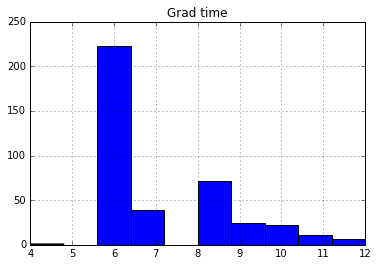

In [44]:
graduation_time.hist()

** In this histogram we see that someone did their bachelor in 4 semesters! That should not be possible. We check. We also note that the histogram x axis looks a bit odd, as there seems to be a hole between semesters 7 and 8 and there isn't.**

In [45]:
graduation_time[graduation_time["Grad time"] == 4]
df_bachelors.loc["204222"]

Gender                     Name  \
2014-2015 Bachelor semestre 5  Monsieur  Séguy Louis Marie James   
          Bachelor semestre 6  Monsieur  Séguy Louis Marie James   
2011-2012 Bachelor semestre 2  Monsieur  Séguy Louis Marie James   
          Bachelor semestre 1  Monsieur  Séguy Louis Marie James   

                              Specialization Minor  SCIPER       Year  \
2014-2015 Bachelor semestre 5                       204222  2014-2015   
          Bachelor semestre 6                       204222  2014-2015   
2011-2012 Bachelor semestre 2                       204222  2011-2012   
          Bachelor semestre 1                       204222  2011-2012   

                                          Semester  
2014-2015 Bachelor semestre 5  Bachelor semestre 5  
          Bachelor semestre 6  Bachelor semestre 6  
2011-2012 Bachelor semestre 2  Bachelor semestre 2  
          Bachelor semestre 1  Bachelor semestre 1

** This means that there is missing data, or maybe Monsieur Séguy changed sections and came back. He is the only outlier **  

**Now let's look at the gender bias**

In [46]:
gender_mean_grad = graduation_time.groupby("Gender").mean()
gender_mean_grad

,Grad time
Gender,
Madame,6.793103
Monsieur,7.105978


**It appears that the female students graduate in slightly less time. But is the difference significant? We use the "two sample T-Test" to see if the difference in means is statistically significant, the null hypothesis being that the two means are identical. Because we know that the sample size is different for the two genders, and we don't know if the variance is the same, we use `equal_var=False` to apply "Welch's t-test," which does not assume equal sample size or variance.**

In [47]:
stats.ttest_ind(
    a=graduation_time[graduation_time["Gender"] == "Madame"]["Grad time"], 
    b=graduation_time[graduation_time["Gender"] == "Monsieur"]["Grad time"], equal_var=False)

Ttest_indResult(statistic=-1.191705695448116, pvalue=0.24162457057331926)

**The statistical test reveals a pvalue of 0.24, which is too large to reject the null hypothesis. We have not found a statistically significant difference between genders.**

# 2nd Part : Master students  

**We now have to fetch the registration data for Master's students and put it in a new dataframe.**

In [48]:
# Only keep options that contain "Master"
master_options = [option for option in options if "Master" in option.text]
master_options

[<option value="2230106">Master semestre 1</option>,
 <option value="942192">Master semestre 2</option>,
 <option value="2230128">Master semestre 3</option>,
 <option value="2230140">Master semestre 4</option>,
 <option value="249127">Projet Master automne</option>,
 <option value="3781783">Projet Master printemps</option>]

**We can ignore the other semester types: we do not take into account internships because they are usually away from EPFL**

In [49]:
master_dict = {option.text : option["value"] for option in master_options}
master_dict

{'Master semestre 1': '2230106',
 'Master semestre 2': '942192',
 'Master semestre 3': '2230128',
 'Master semestre 4': '2230140',
 'Projet Master automne': '249127',
 'Projet Master printemps': '3781783'}

In [50]:
get_df_for_semester("2015-2016", "Master semestre 1", master_dict)

,,,Gender,Name,Specialization,Minor,SCIPER,Year,Semester
251253,2015-2016,Master semestre 1,Madame,Abi Akar Nora,,,251253,2015-2016,Master semestre 1
225654,2015-2016,Master semestre 1,Madame,Aeby Prisca,,,225654,2015-2016,Master semestre 1
257825,2015-2016,Master semestre 1,Monsieur,Alnasser Riyadh Abdulaziz M,,,257825,2015-2016,Master semestre 1
166075,2015-2016,Master semestre 1,Monsieur,Amiguet Jérôme,,,166075,2015-2016,Master semestre 1
213618,2015-2016,Master semestre 1,Monsieur,Amorim Afonso Caldeira Da Silva Pedro Maria,,,213618,2015-2016,Master semestre 1
215623,2015-2016,Master semestre 1,Monsieur,Andreina Sébastien Laurent,,,215623,2015-2016,Master semestre 1
243163,2015-2016,Master semestre 1,Monsieur,Antognini Diego Matteo,,,243163,2015-2016,Master semestre 1
251470,2015-2016,Master semestre 1,Monsieur,Balaban Metin,,,251470,2015-2016,Master semestre 1
226638,2015-2016,Master semestre 1,Monsieur,Beguet Romain Michel,,,226638,2015-2016,Master semestre 1
248358,2015-2016,Master semestre 1,Monsieur,Bell Enea,,,248358,2015-2016,Master semestre 1


**As before, we fetch the data for each semester and create a single dataframe**

In [51]:
# Concatenate all master semesters
dfs = []
for year in year_dict:
    for master in master_dict:
        dfs.append(get_df_for_semester(year, master, master_dict))

df_masters = pd.concat(dfs)
df_masters.sample(5)

,,,Gender,Name,Specialization,Minor,SCIPER,Year,Semester
154484,2008-2009,Master semestre 3,Monsieur,Junod Cyril,Internet computing,,154484,2008-2009,Master semestre 3
155124,2007-2008,Master semestre 3,Monsieur,Yersin Antoine,,,155124,2007-2008,Master semestre 3
218047,2012-2013,Master semestre 1,Monsieur,Shahpaski Marjan,,,218047,2012-2013,Master semestre 1
178656,2010-2011,Master semestre 1,Monsieur,Curreli Alexandre,,,178656,2010-2011,Master semestre 1
170176,2010-2011,Master semestre 2,Monsieur,Pittet Jonathan,,,170176,2010-2011,Master semestre 2


**To calculate the average stay, we need to keep the records who have a Master Project, meaning that they finished their studies.**

In [52]:
# Master projects
df_masters[df_masters["Semester"].str.contains("Projet")]

,,,Gender,Name,Specialization,Minor,SCIPER,Year,Semester
233184,2015-2016,Projet Master automne,Monsieur,Hahling Robin Philippe,,,233184,2015-2016,Projet Master automne
233543,2015-2016,Projet Master automne,Monsieur,Jin Jialei,,Mineur en Biocomputing,233543,2015-2016,Projet Master automne
185301,2014-2015,Projet Master automne,Monsieur,Sarfati Alexandre,,,185301,2014-2015,Projet Master automne
223102,2013-2014,Projet Master automne,Monsieur,Lukovics Akos,,,223102,2013-2014,Projet Master automne
210215,2013-2014,Projet Master automne,Monsieur,Tran Bao Duy,Internet computing,,210215,2013-2014,Projet Master automne
226037,2013-2014,Projet Master automne,Madame,Zerva Chrysoula,,,226037,2013-2014,Projet Master automne
222434,2013-2014,Projet Master printemps,Monsieur,Liu Zongren,,,222434,2013-2014,Projet Master printemps
191471,2010-2011,Projet Master automne,Monsieur,Brot Benoît,,,191471,2010-2011,Projet Master automne
146742,2010-2011,Projet Master automne,Monsieur,Marx Clément,"Signals, Images and Interfaces",,146742,2010-2011,Projet Master automne
191313,2010-2011,Projet Master automne,Monsieur,Prisacari Bogdan,,,191313,2010-2011,Projet Master automne


**There is definitely missing data, as only 128 Master Projects are registered, and most of them appear in 2016-2017. Indeed, looking at is-academia, some years contain no data for Master Projects. We conclude that we simply cannot simply use the Master Project to determine the end of the studies.**

**Thus, to calculate the average stay, we use the following algorithm:**

* discard record if no "Master semestre 2"
* discard record if exists "Spécialisation" or "Mineur" but no "Master semestre 3"
* calculate the delta between last and first semester
* add 6 months if student has no record of a "Master project"

In [53]:
len(df_masters)

2844

In [54]:
# A function to find people that we consider to have finished their master
def finished_master(group):
    # Drop if no "Master semestre 1" or no "Master semester 2"
    if not ((group['Semester'].isin(["Master semestre 1"])).any() and (group['Semester'].isin(["Master semestre 2"])).any()):
        return False
    # Drop if has a Specialization or a Minor, but no "Master semestre 3"
    if group['Specialization'].any() or group['Minor'].any():
        if not (group['Semester'].isin(["Master semestre 3"])).any():
            return False
    
    return True
         
df_masters_finished = df_masters.groupby(by="SCIPER").filter(finished_master)

In [55]:
print(len(df_masters), len(df_masters_finished))

2844 2546


In [56]:
# Calculates the number of semesters. 
def master_time(group):
    delta = len(group['Semester'])
    
    # We add a semester if no entry for a "Projet Master"
    if not (group['Semester'].isin(["Projet Master automne", "Projet Master printemps"])).any():
        delta += 1 
    
    return delta

master_stay_semesters = df_masters_finished.groupby(by="SCIPER").apply(master_time)
master_stay_semesters.head(10)

SCIPER
146330    4
146742    7
146929    3
147008    5
152232    4
153066    7
153746    4
153762    5
154080    6
154573    6
dtype: int64

**Let's see if our algorithm gives reasonable results! The describe() function is always useful to see if anything crazy is happening**

In [57]:
master_stay_semesters.describe()

count    748.000000
mean       4.251337
std        0.954626
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        8.000000
dtype: float64

In [58]:
# We check for people who did 8 semesters
master_stay_semesters[master_stay_semesters == 8]

SCIPER
166491    8
179988    8
181244    8
204393    8
dtype: int64

**We check one of the 8-semester students to see what they have been up to.**

In [59]:
df_masters.loc["181244"]

Gender            Name      Specialization  \
2015-2016 Master semestre 2  Monsieur  Jolidon Fabien  Internet computing   
          Master semestre 3  Monsieur  Jolidon Fabien  Internet computing   
2014-2015 Master semestre 2  Monsieur  Jolidon Fabien  Internet computing   
          Master semestre 3  Monsieur  Jolidon Fabien  Internet computing   
2013-2014 Master semestre 1  Monsieur  Jolidon Fabien                       
          Master semestre 2  Monsieur  Jolidon Fabien  Internet computing   
2016-2017 Master semestre 3  Monsieur  Jolidon Fabien  Internet computing   

                            Minor  SCIPER       Year           Semester  
2015-2016 Master semestre 2        181244  2015-2016  Master semestre 2  
          Master semestre 3        181244  2015-2016  Master semestre 3  
2014-2015 Master semestre 2        181244  2014-2015  Master semestre 2  
          Master semestre 3        181244  2014-2015  Master semestre 3  
2013-2014 Master semestre 1        181244  2013-2014  Master semestre 1  
          Master semestre 2        181244  2013-2014  Master semestre 2  
2016-2017 Master semestre 3        181244  2016-2017  Master semestre 3

**It's time to create a histogram of the average stay**

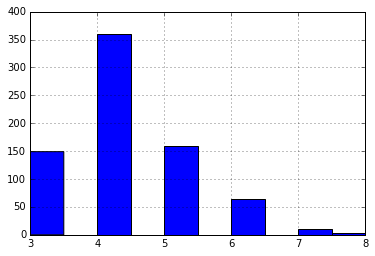

In [60]:
master_stay_semesters.hist()

**So the average stay at epfl for master students is:**

In [61]:
print("{0:.2f} semesters".format(master_stay_semesters.mean()))

4.25 semesters


**Now we calculate the average stay for each specialization offered by the department.**

In [62]:
# Returns True if has Specialization
def has_spec(group):
    return bool(group['Specialization'].any())

# Calculate master time and find specialization
def master_time_spec(group):
    delta = master_time(group)
    
    # Replace empty cells with Nan so we can drop them
    specs = group["Specialization"].replace("", np.nan)
    specs = specs.dropna()
    return pd.Series([delta, specs[0]], index=["Master stay", "Specialization"])

df_masters_spec = df_masters_finished.groupby(by="SCIPER").filter(has_spec)
df_masters_spec = df_masters_spec.groupby(by="SCIPER").apply(master_time_spec)

In [63]:
print("Number of students with specializations: %d" % len(df_masters_spec))

Number of students with specializations: 229


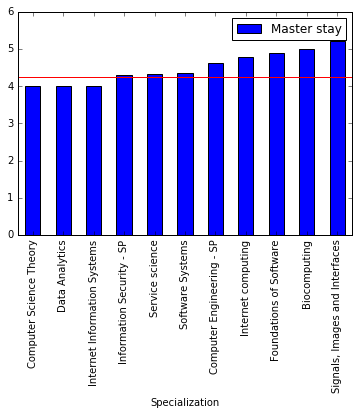

In [64]:
spec_avg = df_masters_spec.groupby(by="Specialization").mean()
spec_avg.sort_values(by="Master stay").plot(kind="bar").axhline(y=master_stay_semesters.mean(), color='red')

** Here we see that people who take a specilalization usually take more time than the general average (in red), which is expected** 

In [65]:
# Before doing any statistical tests, we check that we have enough entries for each specialization
df_masters_spec.groupby(by="Specialization").count()

,Master stay
Specialization,
Biocomputing,4
Computer Engineering - SP,19
Computer Science Theory,1
Data Analytics,3
Foundations of Software,58
Information Security - SP,7
Internet Information Systems,1
Internet computing,88
Service science,3


**Now let's compare each specialization with the general dataset to see if there is a statistical difference between the means. We use Welch's t-test again because we don't want to assume anything about the sample size or variance of each specialization. Some of the specializations have too few students to use statistical tests so we do not consider them.**

In [66]:
def compare_spe_general(spe):
    # We consider only specializations where at least 5 people have graduated from.  
    if len(spe) <= 5:
        return None
    return stats.ttest_ind(a=spe["Master stay"], b=master_stay_semesters, equal_var=False)[1] # we output the p-value 

# Run statistical tests on each specialization; drop NaN results
df_masters_spec.groupby(by="Specialization").apply(compare_spe_general).dropna().sort_values()

Specialization
Foundations of Software           0.000002
Internet computing                0.000003
Signals, Images and Interfaces    0.000175
Computer Engineering - SP         0.045581
Software Systems                  0.424514
Information Security - SP         0.860315
dtype: float64

** We see that some specializations have a statistically significant difference with the overall mean. For example for a confidence level of at least 95% "Foundations of Software", "Internet Computing", "Signals, Images and Interfaces", and "Computer Engineering - SP" would stand out. We must be careful though because some of these specializations have a small sample size.**

## BONUS: We perform the same gender-based study from Part 1 but with Master's students this time. ##

In [67]:
# First, convert length of stay data to dataframe
df_stay = master_stay_semesters.to_frame()
df_stay.columns = ['Master stay']
df_stay.head()

,Master stay
SCIPER,
146330,4
146742,7
146929,3
147008,5
152232,4


**We extract each student's starting year year as an integer to use for the plot. Then we create a dataframe with the year, the gender, and the mean stay length for students of that gender who started in that year.**

In [68]:
def get_start_year(group):
    return group['Year'].first()
    
# Get a row from each finished student's first year so that we can plot stay length vs. start year
finished_start_year = df_masters_finished.sort_values(by='Year').groupby('SCIPER').apply(lambda g:int(g['Year'].min().split('-')[0]))
finished_start_year = finished_start_year.to_frame()
finished_start_year.columns = ['Start year']
finished_start_year.head()

# Join then groupby to get the mean stay length for a given (startYear,gender)
df_stay_by_year_gender = df_masters_finished.join(finished_start_year, on='SCIPER')
df_stay_by_year_gender = df_stay_by_year_gender.join(df_stay,on='SCIPER')
mean_year_gender = df_stay_by_year_gender.groupby(['Start year', 'Gender']).mean()
mean_year_gender

Master stay
Start year Gender               
2007       Madame       3.888889
           Monsieur     4.378788
2008       Madame       4.238095
           Monsieur     4.263158
2009       Madame       4.400000
           Monsieur     4.364238
2010       Madame       5.113636
           Monsieur     4.541353
2011       Madame       4.452830
           Monsieur     4.610236
2012       Madame       4.853659
           Monsieur     4.702479
2013       Madame       4.553191
           Monsieur     4.841379
2014       Madame       5.000000
           Monsieur     4.865014
2015       Madame       3.928571
           Monsieur     3.807074

In [69]:
# Unstack the genders to get the 
myg = mean_year_gender.unstack()
myg
# TODO scatter plot!

Master stay          
Gender          Madame  Monsieur
Start year                      
2007          3.888889  4.378788
2008          4.238095  4.263158
2009          4.400000  4.364238
2010          5.113636  4.541353
2011          4.452830  4.610236
2012          4.853659  4.702479
2013          4.553191  4.841379
2014          5.000000  4.865014
2015          3.928571  3.807074

**We didn't have time to make a scatter plot but can compare the trends over time between the two genders with this table!**